## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

In [354]:
pip install ml_metrics

Note: you may need to restart the kernel to use updated packages.


In [355]:
import pandas as pd
from ml_metrics import rmse
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from math import sqrt
#import numpy as np
from sklearn.tree import DecisionTreeRegressor

# 1. Подготовка

In [356]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0]) 
data.sort_index(inplace=True)

In [357]:
data = data.resample('1H').sum() # ресемплирование по одному часу

In [358]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
num_orders    4416 non-null int64
dtypes: int64(1)
memory usage: 69.0 KB


In [359]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Данные готовы для анализа.

# 2. Анализ

In [360]:
decomposed = seasonal_decompose(data) # разделение на трендовую, сезонную и шумовую состовляющие

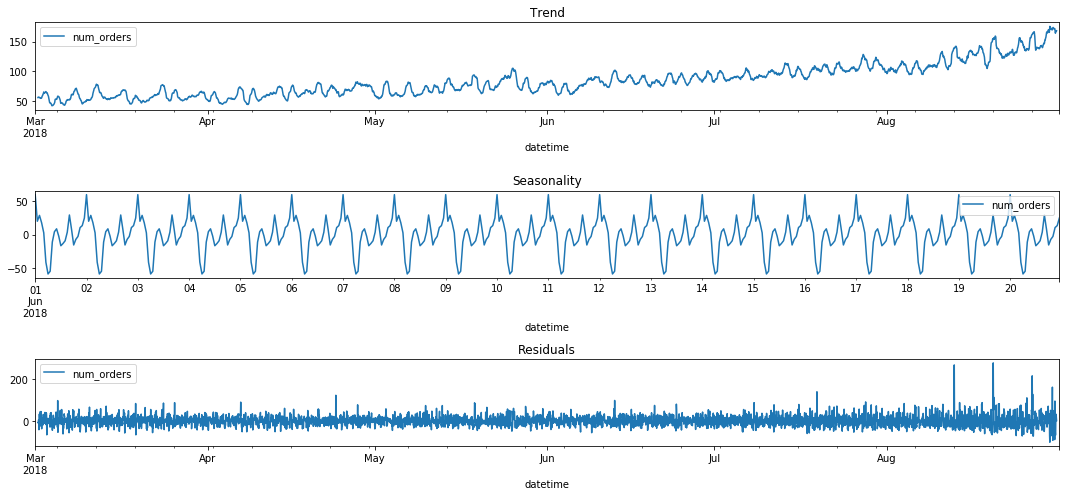

In [361]:
plt.figure(figsize=(15, 7)) # графическая итерпритация
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca()) # трендовая зависимость
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal['2018-06-01':'2018-06-20'].plot(ax=plt.gca()) # сезонная зависимость
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) # шумы
plt.title('Residuals')
plt.tight_layout()

1. Тренд равномерного роста заказов за пол года.
2. Наблюдается сезонная (ежедневная) закономерность заказов. Рост с 6 утра до 12 ночи. Спад в ночные часы.

In [362]:
def make_features(data, max_lag, rolling_mean_size): # функция выделения лаг и скользящего среднего
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [363]:
make_features(data, 4, 1) # задаем количество лаг и коридор скользящего среднего

In [364]:
train, test = train_test_split(data, shuffle=False, test_size=0.1) # разбивка на тестовую и обучающую выборку без перемешивания
train = train.dropna() # удаление строк содержащих NaN

features_train = train.drop(['num_orders'], axis=1) # выделение признаков
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

# 3. Обучение

### 3.1 LinearRegression

In [365]:
model_1 = LinearRegression()
model_1.fit(features_train, target_train)
predicted_train_LR = model_1.predict(features_train)
predicted_test_LR = model_1.predict(features_test)

In [366]:
rmse(target_train, predicted_train_LR)

30.500374252442192

### 3.2 DecisionTreeRegressor

In [367]:
model_2 = DecisionTreeRegressor(random_state=12345)
parameters_2 = {'max_depth':[10,11,13,15,17,19,21]}
grid_2 = GridSearchCV(estimator=model_2, param_grid = parameters_2, cv = 2, n_jobs=-1)
grid_2.fit(features_train, target_train)

GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=DecisionTreeRegressor(criterion='mse', max_depth=None,
                                             max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort=False, random_state=12345,
                                             splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [10, 11, 13, 15, 17, 19, 21]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [368]:
predicted_train = grid_2.predict(features_train)
rmse(target_train, predicted_train)

16.21990552852512

### 3.3 RandomForestRegressor

In [369]:
model_3 = RandomForestRegressor(random_state=12345)
parameters_3 = {'max_depth':[6,8,10,20], 'n_estimators':[30, 50, 70, 100]}
grid_3 = GridSearchCV(estimator=model_3, param_grid = parameters_3, cv = 2, n_jobs=-1)
grid_3.fit(features_train, target_train)  

GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False,
                                             random_state=12345, verbose=0,
                                             warm_start=False),
             iid='warn', n_jobs=-1,
            

In [370]:
predicted_train = grid_3.predict(features_train)
rmse(target_train, predicted_train)

8.432185087445406

# 4. Тестирование

### 4.1 LinearRegression

In [373]:
predicted_test_LR = model_1.predict(features_test)

In [374]:
rmse(target_test, predicted_test_LR)

52.574506853736935

### 4.2 DecisionTreeRegressor

In [375]:
predicted_test_DTR = grid_2.predict(features_test)

In [376]:
rmse(target_test, predicted_test_DTR)

51.814648002372586

### 4.3 RandomForestRegressor

In [377]:
predicted_test_DFR = grid_3.predict(features_test)

In [378]:
rmse(target_test, predicted_test_DFR)

46.78635892380203

Полученное значение RMSE модели случайного леса на тестовой выборке соотвествует заданию (не больше 48). 